# Data Summarization - Construction permits, part 2/2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aggregate-points" data-toc-modified-id="Aggregate-points-1">Aggregate points</a></span></li><li><span><a href="#Aggregation-results" data-toc-modified-id="Aggregation-results-2">Aggregation results</a></span></li><li><span><a href="#Enrich-the-data" data-toc-modified-id="Enrich-the-data-3">Enrich the data</a></span></li><li><span><a href="#Share-your-work" data-toc-modified-id="Share-your-work-4">Share your work</a></span></li></ul></div>

In the "Explore and analyze construction permits" notebook, we explored your data and learned a little about the spatial and temporal trends of permit activity in Montgomery County. In this lesson, we'll move beyond exploration and run spatial analysis tools to answer specific questions that can't be answered by the data itself. In particular, we want to know why permits spiked in Germantown in 2011 and predict where future permit spikes - and, by extension, future growth - are likely to occur.

First, we'll aggregate the points by ZIP Code. We'll enrich each ZIP Code with demographic information and learn more about the demographic conditions that led to such rapid growth in such a short time. Once you determine why growth occurred where and when it did, we'll locate other ZIP Codes with similar demographic characteristics to predict future growth.

## Aggregate points

In [1]:
from arcgis import GIS

In [2]:
gis = GIS("home")

<Item title:"Commercial_Permits_since_2010" type:Feature Layer Collection owner:api_data_owner>
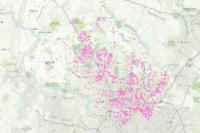

In [3]:
data = gis.content.search("Commercial_Permits_since_2010 owner:api_data_owner",
                          'Feature layer',
                           outside_org=True)
data[0]

In [4]:
permits = data[0]
permit_layer = permits.layers[0]

<Item title:"United States ZIP Code Boundaries 2021" type:Feature Layer Collection owner:esri_dm>
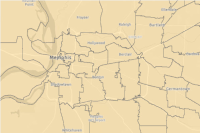

In [5]:
zip_item = gis.content.get('a1569e93ecd2408d89f42e8770a90f76')
zip_item

The USA_ZIP_item layer is added as a new item. Since the item is a feature layer collection, using the layers property will give us a list of layers.

In [6]:
for lyr in zip_item.layers:
    print(lyr.properties.name)

USA_Country
USA_State
USA_County
USA_ZipCode
USA_Tract
USA_BlockGroup


In [7]:
zip_code_layer = zip_item.layers[3]

Next, you'll use this layer to aggregate permit points. By default, the parameters are set to use the ZIP Codes as the area layer, the permits as the layer to be aggregated, and the layer style to be based on permit count. These parameters are exactly what you want.

In [8]:
from arcgis.features.summarize_data import aggregate_points
from datetime import datetime as dt

In [9]:
permit_agg_by_zip = aggregate_points(permit_layer, zip_code_layer, 
                                     keep_boundaries_with_no_points=False,
                                     output_name='zipcode_aggregate_' + str(dt.now().microsecond))

{"cost": 43.425}


In [10]:
permit_agg_by_zip

<Item title:"zipcode_aggregate_867427" type:Feature Layer Collection owner:arcgis_python>

## Aggregation results

In [11]:
agg_map = gis.map("Montgomery County, Maryland")
agg_map.add_layer(permit_agg_by_zip)

In [12]:
agg_map

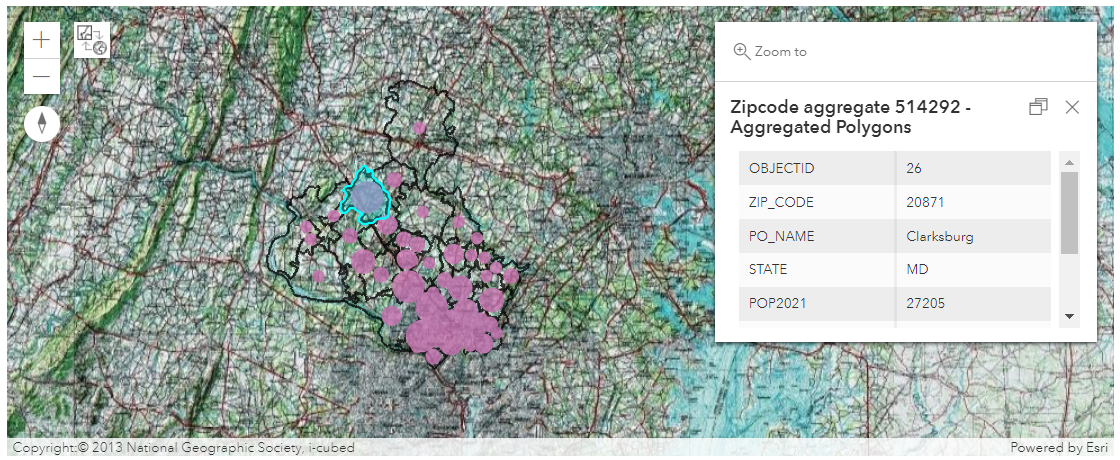

The new layer looks like a point layer, but it's actually a polygon layer with a point symbology. Each point represents the number of permits per ZIP Code area. Larger points indicate ZIP Codes with more permits.

In [13]:
import pandas as pd

In [14]:
sdf = pd.DataFrame.spatial.from_layer(permit_agg_by_zip.layers[0])

In [15]:
sdf.head(10)

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Point_Count,AnalysisArea,SHAPE
0,1,20012,Washington,DC,15139,2.36,6,6.103444,"{""rings"": [[[-77.0524151, 38.9865583], [-77.05..."
1,2,20783,Hyattsville,MD,46888,6.25,1,16.194162,"{""rings"": [[[-77.002459, 38.96569], [-77.00242..."
2,3,20814,Bethesda,MD,31304,5.11,1143,13.233003,"{""rings"": [[[-77.1325511, 39.0259945], [-77.13..."
3,4,20815,Chevy Chase,MD,29530,5.35,584,13.866827,"{""rings"": [[[-77.1122705, 38.9738032], [-77.11..."
4,5,20816,Bethesda,MD,16159,4.61,155,11.935862,"{""rings"": [[[-77.1795738, 38.9683754], [-77.17..."
5,6,20817,Bethesda,MD,37751,13.89,734,35.980035,"{""rings"": [[[-77.2136659, 38.9785558], [-77.21..."
6,7,20818,Cabin John,MD,1276,0.98,13,2.540313,"{""rings"": [[[-77.1793107, 38.9697979], [-77.17..."
7,8,20832,Olney,MD,24723,9.43,212,24.412097,"{""rings"": [[[-77.112229, 39.183879], [-77.1119..."
8,9,20833,Brookeville,MD,8250,22.87,40,59.226278,"{""rings"": [[[-77.114838, 39.267372], [-77.1148..."
9,10,20837,Poolesville,MD,6092,42.1,51,109.04284,"{""rings"": [[[-77.503682, 39.115185], [-77.5030..."


In [16]:
sdf.reset_index(inplace=True)

In [17]:
sdf.head()

,index,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Point_Count,AnalysisArea,SHAPE
0,0,1,20012,Washington,DC,15139,2.36,6,6.103444,"{""rings"": [[[-77.0524151, 38.9865583], [-77.05..."
1,1,2,20783,Hyattsville,MD,46888,6.25,1,16.194162,"{""rings"": [[[-77.002459, 38.96569], [-77.00242..."
2,2,3,20814,Bethesda,MD,31304,5.11,1143,13.233003,"{""rings"": [[[-77.1325511, 39.0259945], [-77.13..."
3,3,4,20815,Chevy Chase,MD,29530,5.35,584,13.866827,"{""rings"": [[[-77.1122705, 38.9738032], [-77.11..."
4,4,5,20816,Bethesda,MD,16159,4.61,155,11.935862,"{""rings"": [[[-77.1795738, 38.9683754], [-77.17..."


Review some basic statistics about the data.

In [18]:
sdf['Point_Count'].mean()

249.42222222222222

In [19]:
sdf['Point_Count'].max()

1143

In [20]:
sdf['Point_Count'].min()

1

In [21]:
agg_layer = permit_agg_by_zip.layers[0]

Although most of the large point symbols on the map are in the southeast corner, near Washington, D.C., there are a few large points in the northwest. In particular, there is a very large circle in the ZIP Code located in Clarksburg. (If you're using different ZIP Code data, this area may be identified as ZIP Code 20871 instead.) The ZIP code has 948 permits. Additionally, this area geographically corresponds to the hot spot you identified in the previous lesson. This ZIP Code is one that you'll focus on when you enrich your layer with demographic data.

## Enrich the data

Are there demographic characteristics about the Clarksburg ZIP Code that contributed to its high growth? If so, are there other areas with those characteristics that may experience growth in the future? To answer these questions, you'll use the **Enrich Data** analysis tool. This tool adds demographic attributes of your choice to your data. Specifically, you'll add Tapestry information to each ZIP Code. <a href="https://www.esri.com/en-us/arcgis/products/tapestry-segmentation/overview">Tapestry</a> is a summary of many demographic and socioeconomic variables, including age groups and lifestyle choices. It'll teach you more about the types of people who live in your area of interest and help you better understand the reasons why growth happened where it did.

In [22]:
from arcgis.features.enrich_data import enrich_layer

In [23]:
enrich_aggregate = enrich_layer(agg_layer, 
                                analysis_variables=["AtRisk.TSEGNAME"],
                                output_name="added_tapestry_var_" + str(dt.now().microsecond))

{"cost": -1}


In [24]:
enrich_aggregate

<Item title:"added_tapestry_var_645372" type:Feature Layer Collection owner:arcgis_python>

In [25]:
agg_lyr = enrich_aggregate.layers[0]

In [26]:
sdf = pd.DataFrame.spatial.from_layer(agg_lyr)

In [27]:
sdf.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,SQMI,Point_Count,AnalysisArea,ID,sourceCountry,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TSEGNAME,SHAPE
0,1,20012,Washington,DC,15139,2.36,6,6.103444,0,US,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,City Lights,"{""rings"": [[[-77.0524151, 38.9865583000001], [..."
1,2,20783,Hyattsville,MD,46888,6.25,1,16.194162,1,US,2,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,NeWest Residents,"{""rings"": [[[-77.002459, 38.9656900000001], [-..."
2,3,20814,Bethesda,MD,31304,5.11,1143,13.233003,2,US,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,Metro Renters,"{""rings"": [[[-77.1325510999999, 39.0259945], [..."
3,4,20815,Chevy Chase,MD,29530,5.35,584,13.866827,3,US,4,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,Top Tier,"{""rings"": [[[-77.1122705, 38.9738032000001], [..."
4,5,20816,Bethesda,MD,16159,4.61,155,11.935862,4,US,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,Top Tier,"{""rings"": [[[-77.1795738, 38.9683754000001], [..."


In [28]:
enrich_aggregate_map = gis.map('Montgomery County, Maryland')

In [29]:
enrich_aggregate_map

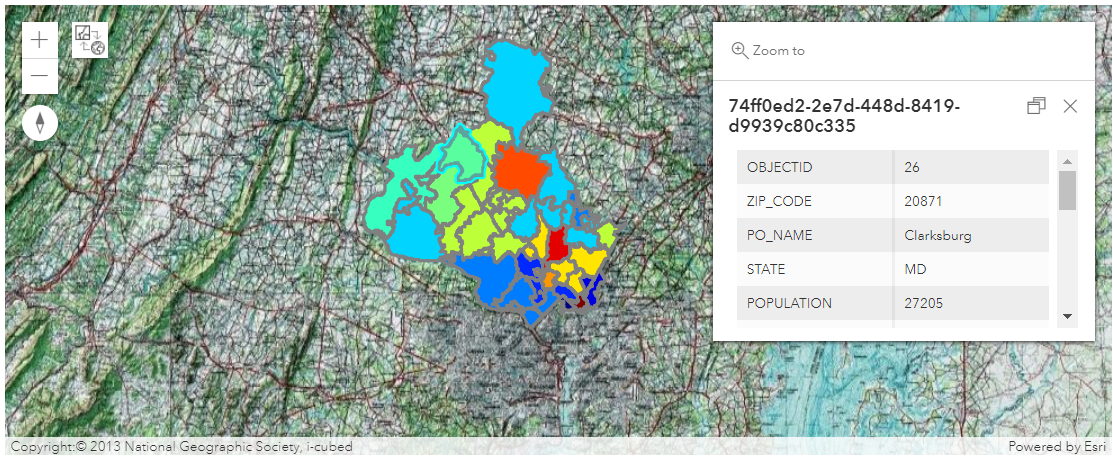

In [30]:
sdf.spatial.plot(kind='map', map_widget=enrich_aggregate_map,
        renderer_type='u',
        col='TSEGNAME') 

True

Click some of the ZIP Codes.

The Tapestry segment is displayed when you click a ZIP Code. The Tapestry segments have names such as Enterprising Professionals and Savvy Suburbanites. You can look up more information about each segment, including its specific demographic characteristics, on the<a href="http://doc.arcgis.com/en/esri-demographics/data/tapestry-segmentation.htm"> Tapestry Segmentation help page</a>.

What Tapestry segment is dominant for the Clarksburg ZIP Code where major growth occurred? Click the Clarksburg ZIP Code to find out. According to the pop-up, Boomburbs is the dominant Tapestry segment for the ZIP Code. Boomburbs have many young professionals with families living in affordable new housing. This description may explain why the area saw such rapid residential growth in 2011. It's possible that other ZIP Codes with similar demographic profiles may experience rapid growth in the near future.

Click the ZIP Code directly southwest of Clarksburg.

This ZIP Code is in Boyds. It also has the Boomburbs Tapestry segment. However, its number of permits has been relatively low since 2010. The county may be able to anticipate a similar spike in permit activity in this area.

Although Tapestry segments are based on several demographic characteristics, you could also perform this analysis with other variables. For instance, you could determine if there is a correlation between high permit activity and high population growth. Is a young population or a high income level a stronger indicator of growth? You can answer these questions and others with the analysis tools at your disposal. For the purposes of this lesson, however, your results are satisfactory.

In [31]:
enrich_aggregate_map.add_layer(agg_lyr, {'renderer':'ClassedSizeRenderer',
                                             'field_name':'POPULATION',
                                             'opacity':0.75})

## Share your work

We've analyzed your data and come to a couple conclusions about your data. Next, we'll share your results online. Currently, our result layers are layers that are accessible only to you. Sharing our data will make it easier for county officials to use your data in other ArcGIS applications and communicate key information to the public. In particular, we'll share your work to ArcGIS Online. We'll share your enriched ZIP Codes dataset as feature layers that can be added to any web map. 

The layer contains fields for both the count of permits per ZIP Code and the dominant Tapestry segment—basically all of the result data we created in your analysis. We'll only need to share this layer, not the original aggregation layer.

Using the `share()` method you can share your work with others.

In [32]:
enrich_aggregate.share(everyone=True)

{'results': [{'itemId': 'dd367413d9dd4823be06903892124e0c',
   'success': True,
   'notSharedWith': []}]}

In this notebook, we used ArcGIS API for Python to explore and analyze permit data for Montgomery County, Maryland. You answered questions about your data's spatial and temporal trends and located areas of the county with rapid growth. We compared your findings with demographic data, came to conclusions about the possible causes of growth, and even predicted an area that may experience similar growth in the future based on shared demographic characteristics. With ArcGIS API for Python, we can perform a similar workflow on any of your data to better understand what it contains and what questions it can answer.